In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import tensorflow_datasets as tfds

# 데이터 불러오기

In [2]:
# train, test 데이터 불러오기

train_path = './data/train.csv' # 필요에 따라 변경하세요.
test_path = './data/test.csv' # 필요에 따라 변경하세요.
train_normal_data_path = './data/일반대화 합성데이터(GPT-4o, AIhub 참고).csv'

def load_data(file_path):
    df = pd.read_csv(file_path)
    
    return df

train_df = load_data(train_path)
test_df = load_data(test_path)
normal_df = load_data(train_normal_data_path)

In [3]:
# 데이터 확인
train_df.shape, test_df.shape, normal_df.shape

((3950, 3), (500, 2), (1000, 3))

In [4]:
# train data 와 normal 데이터 합치기
def concat_train_normal(train_df, normal_df):
    train_df = pd.concat([train_df, normal_df], ignore_index=True)
    train_df.drop(['idx'], axis=1, inplace=True)
    train_df.reset_index(inplace=True)

    return train_df

train_df = concat_train_normal(train_df, normal_df)
train_df.head()

,index,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
# 클래스 숫자로 변환
def class_encoding(train_df, class_mapping):
    train_df['class_encoded'] = train_df['class'].replace(class_mapping)
    
    return train_df

# 클래스 매핑 딕셔너리 정의
class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

train_df = class_encoding(train_df, class_mapping)

# 변환된 데이터 확인
train_df.head()


,index,class,conversation,class_encoded
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,0
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,3
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,1
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,1


In [6]:
train_df.tail()

,index,class,conversation,class_encoded
4945,4945,일반 대화,요즘 나는 축구 배워보고 싶다 키키\n축구? 축구 룰에 대해서는 알아?\n오오 알지...,4
4946,4946,일반 대화,프로게이머들은 좋아하는 거 하고 돈 버니까 좋겠다 키키\n부럽. 임요한 진짜 돈 많...,4
4947,4947,일반 대화,너는 해외여행 자주 다니는 편이야? 키키\n아니. 비행기 타는 걸 안 좋아해서 해외...,4
4948,4948,일반 대화,겨울에 눈이 제발 적게 오면 좋겠다\n나도 키키 어릴 땐 눈 오는 게 되게 좋아했었...,4
4949,4949,일반 대화,요즘은 비나 태풍이 한번 와도 피해가 큰 듯\n어 ㅠㅠ 나는 아직 태풍 매미를 잊지...,4


In [7]:
# 중복된 'conversation' 제거
train_df = train_df.drop_duplicates(subset=['conversation'])

# 중복 제거 후 데이터 확인
print(f"중복 제거된 후 데이터 수: {train_df.shape[0]}")

중복 제거된 후 데이터 수: 4846


In [8]:
from sklearn.model_selection import train_test_split

# 1️⃣ 먼저 데이터를 섞기
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 2️⃣ 60%: 훈련 데이터 분할
train_data, temp_data = train_test_split(train_df, test_size=0.4, random_state=42, stratify=train_df['class_encoded'])

# 3️⃣ 남은 40% 중 50%를 검증, 50%를 테스트로 나누기 (즉, 20%씩)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['class_encoded'])

# 4️⃣ 결과 확인
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 2907, Validation size: 969, Test size: 970


In [9]:
train_data.head()

,index,class,conversation,class_encoded
1145,4829,일반 대화,제주도 스포츠카 사건 알아?\n나 모르는데 무슨 일 있었어?\n그알에도 나왔다던데 ...,4
755,2000,협박 대화,내 과거 니가 인터넷에 글 올렸어?\n 어 나 맞아 니 잘 되는꼴 보기싫어서 글 올...,0
4273,4029,일반 대화,아니 왜 이렇게 싸워 . 진짜 요즘 이런 거 사회적 문제임\n사회적 문제는 내 통장...,4
3275,2012,기타 괴롭힘 대화,민주야 이 샌드위치 먹어볼래? 내가 집에서 아침에 만들어왔어.\n우와 한 번 먹어봐...,3
2580,2865,직장 내 괴롭힘 대화,회의중에 어딜갔다 오는거지? \n죄송합니다 화장실이 너무 급해서\n뭐? 화장실? 미...,2


In [10]:
val_data.head()

,index,class,conversation,class_encoded
1471,2033,협박 대화,지금 핵무기발사 비밀번호를 말해라\n나는 절대 핵무기발사 비밀번호를 알려줄수 없다\...,0
1494,4265,일반 대화,야구는 좀 보는 편임?\n아니 키키 주변에 야빠들이 많아서 오히려 반발심이...\n...,4
4677,768,기타 괴롭힘 대화,야 넌 체육 수행평가 만점이라며?\n야 좋겠다 나도 다리 병신이었으면 얼마나 좋았을...,3
3313,4366,일반 대화,피파 온라인 오랜만에 하니까 엄청 재밌네 키키\n피파 온라인이 아직도 서비스 운영 ...,4
2699,1475,갈취 대화,야 너 멈춰봐\n네 저요?\n어 너 신발도 벨트도 가방도 좋은거 한다?\n아. 네....,1


In [11]:
test_data.head()

,index,class,conversation,class_encoded
568,4844,일반 대화,고양이나 입양해서 길러 그게 답이야\n고양이는 대마도 가면 주워서 키우려고 키키\n...,4
3955,2729,기타 괴롭힘 대화,배달왔습니다!\n아 배달이네 배달온거 저기 냉장고에 넣고 넣는 김에 냉장고도 정리해...,3
4439,2593,협박 대화,오 깡패다\n니 지금 뭐라했노\n말하는것도 깡패네\n닌 죽었다 시키야 어디서 건방지...,0
2557,3247,기타 괴롭힘 대화,야 너 뭐하냐\n공부해\n뭔공부\n토익공부\n그런다고 점수 올릴 수 있겠니?\n왜 ...,3
2507,2807,기타 괴롭힘 대화,여기 점장 어디 계신가요?\n손님 무슨 일이십니까?\n여기서 산 옷이 엉망이라서요 ...,3


# 전처리

In [12]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 개행 문자("\n")를 공백으로 변환
  sentence = re.sub(r"\n", " ", sentence)
    
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # ?.!, 앞뒤로 공백 추가
  sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 공백 한개의 공백으로

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z\u1100-\u11FF\uAC00-\uD7AF.,?!]", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [13]:
conversation = train_df['conversation'].apply(preprocess_sentence)
conversation

0       김대리 주말에 뭐해 가족끼리 오랜만에 밥먹기로 했습니다 아니 가족은 매일 같이 밥먹...
1       씨 . 일로와봐 네 ? 무슨일이시죠 ? 이거 . 보고서 틀렸잖아 . 일똑바로 안해 ...
2       야 너네 길동중학교지 ? 네 ? 네 . 나 거기 나왔는데 니네 수근이알지 ? 아 네...
3       언니 서울 한복판에 황소가 출몰했대 키키 엥 ? 뭐라고 ? 뭐가 나와 ? 어떤 아저...
4       그렇구나 근데 마침 니가 딱 이걸 샀네 내가 드는게 더 예쁠 것 같은데 어 ? 내놓...
                              ...                        
4841    근데 이게 진짜 이런 사소한 문제를 넘어서 큰 문제도 많잖아 올 여름에 미국은 홍수...
4842    너가 내 여자친구 좋아한다고 했냐 ? 와 저런 오타쿠가 그랬다고 ? 꼴값이다 진짜 ...
4843    아 네 안녕하세요 ! 혹시 가지고 계신 폰이 제 건데 어디서 주웠는지 알 수 있을까...
4844    이름이 진짜 신기하다 나무가 뭐야 ? 나무 ? 무슨 나무야 ? 소나무 ? 왜그래 ....
4845    야 ! 너 이거 뭐야 뭐가 ? 내 사진 도용해서 왜 나인척하고 다녀 아 그냥 재미로...
Name: conversation, Length: 4846, dtype: object

In [14]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(conversation, target_vocab_size=2**13)

In [15]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8144


In [16]:
# 1998번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 1998번째 질문 샘플: {}'.format(tokenizer.encode(conversation[1998])))

정수 인코딩 후의 1998번째 질문 샘플: [6950, 7918, 7, 8, 4391, 5012, 2, 35, 42, 25, 53, 77, 3171, 3570, 2, 3096, 301, 586, 294, 1266, 4090, 1471, 2423, 7918, 93, 2, 555, 287, 92, 25, 322, 3505, 4524, 94, 7455, 1335, 2342, 240, 2, 53, 6432, 163, 258]


In [17]:
# 원본 확인
conversation[1998].split()

['오랜만이다',
 '너',
 '나',
 '피해',
 '다니냐',
 '?',
 '아니',
 '근데',
 '왜',
 '난',
 '그렇게',
 '느껴지지',
 '?',
 '지난번',
 '맞은곳',
 '아파서',
 '병원',
 '있었어',
 '그래',
 '?',
 '어디더라',
 '그건',
 '왜',
 '거기',
 '빼고',
 '맞자',
 '제발',
 '이러지마',
 '이러지말까',
 '?',
 '난',
 '재밌는데',
 '?']

In [18]:
# 각 데이터의 토큰 개수 세기
temp = list(map(lambda x : len(x.split()), conversation))
temp[:5]

[90, 55, 55, 114, 50]

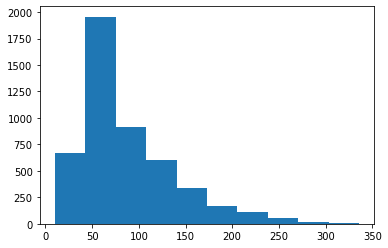

In [19]:
# 각 데이터의 토큰 개수 시각화 - histplot
import matplotlib.pyplot as plt

plt.hist(temp)
plt.show()

In [20]:
print(f'MAX_LENGTH = 200 일때: {np.array([True if x <= 200 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')
print(f'MAX_LENGTH = 100 일때: {np.array([True if x <= 100 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')
print(f'MAX_LENGTH = 50 일때: {np.array([True if x <= 50 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')

MAX_LENGTH = 200 일때: 95.81 %
MAX_LENGTH = 100 일때: 70.66 %
MAX_LENGTH = 50 일때: 24.04 %


In [21]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 100
print(MAX_LENGTH)

100


In [22]:
# 최대 길이를 초과하는 샘플은 데이터 자르기, 패딩
def tokenize_and_filter(inputs):
  tokenized_inputs = list()
  
  for sentence in inputs:
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence = tokenizer.encode(sentence)

    # 최대 길이 200 까지만 데이터셋으로 사용
    if len(sentence) <= MAX_LENGTH:
      tokenized_inputs.append(sentence)
    
    else:
      tokenized_inputs.append(sentence[:MAX_LENGTH])
  
  # 최대 길이 200으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

In [23]:
conversation = tokenize_and_filter(conversation)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 대화 샘플 개수: {}'.format(len(conversation)))

단어장의 크기 : 8144
필터링 후의 대화 샘플 개수: 4846


# 모델링 - transformer 인코딩 모델 밑바닥부터 구현하기

In [24]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 헤드 어텐션 구현하기
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 패딩 마스크 구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 인코더 생성하기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [25]:
# 인코더만 구성하기
def my_encoder(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="my_encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # Global Average Pooling 적용 (or Max Pooling 가능)
  outputs = tf.keras.layers.GlobalMaxPooling1D()(enc_outputs)

  # 완전연결층
  outputs = tf.keras.layers.Dense(256, activation="relu", name='dense1')(outputs)
  outputs = tf.keras.layers.Dense(128, activation="relu", name='dense2')(outputs)
  outputs = tf.keras.layers.Dense(units=5, activation="softmax", name='outputs')(outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [26]:
# 모델 생성하기
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = my_encoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "my_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3139072     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           encoder[0][0]           

In [27]:
# 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping & ModelCheckpoint 설정
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

model_checkpoint = ModelCheckpoint(
    "best_model", monitor='val_loss', save_best_only=True, mode='max', verbose=1, save_format="tf", save_weights_only=True)

callbacks = [early_stopping, model_checkpoint]


In [29]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

def get_dataset(data):
    conversation = data['conversation'].apply(preprocess_sentence)
    conversation = tokenize_and_filter(conversation)

    dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': conversation},  # 입력 데이터
    {'outputs': data['class_encoded'].values}  # 출력 데이터 (라벨)
    ))
    
    dataset = dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_dataset = get_dataset(train_data)
val_dataset = get_dataset(val_data)
test_dataset = get_dataset(test_data)

In [32]:
# 데이터셋 크기 출력
print(f"Train size: {train_dataset}, Validation size: {val_dataset}, Test size: {test_dataset}")


Train size: <PrefetchDataset shapes: ({inputs: (None, 100)}, {outputs: (None,)}), types: ({inputs: tf.int32}, {outputs: tf.int64})>, Validation size: <PrefetchDataset shapes: ({inputs: (None, 100)}, {outputs: (None,)}), types: ({inputs: tf.int32}, {outputs: tf.int64})>, Test size: <PrefetchDataset shapes: ({inputs: (None, 100)}, {outputs: (None,)}), types: ({inputs: tf.int32}, {outputs: tf.int64})>


In [33]:
train_dataset

<PrefetchDataset shapes: ({inputs: (None, 100)}, {outputs: (None,)}), types: ({inputs: tf.int32}, {outputs: tf.int64})>

Epoch 1/100
46/46 [==============================] - 5s 49ms/step - loss: 1.6982 - accuracy: 0.1947 - val_loss: 1.5954 - val_accuracy: 0.2549

Epoch 00001: val_loss improved from -inf to 1.59542, saving model to best_model
Epoch 2/100
46/46 [==============================] - 2s 37ms/step - loss: 1.5751 - accuracy: 0.2769 - val_loss: 1.5221 - val_accuracy: 0.3302

Epoch 00002: val_loss did not improve from 1.59542
Epoch 3/100
46/46 [==============================] - 2s 37ms/step - loss: 1.4852 - accuracy: 0.3509 - val_loss: 1.4238 - val_accuracy: 0.3736

Epoch 00003: val_loss did not improve from 1.59542
Epoch 4/100
46/46 [==============================] - 2s 37ms/step - loss: 1.3594 - accuracy: 0.4235 - val_loss: 1.2592 - val_accuracy: 0.3963

Epoch 00004: val_loss did not improve from 1.59542
Epoch 5/100
46/46 [==============================] - 2s 37ms/step - loss: 1.1843 - accuracy: 0.4802 - val_loss: 1.1126 - val_accuracy: 0.4737

Epoch 00005: val_loss did not improve from 1.59542
E

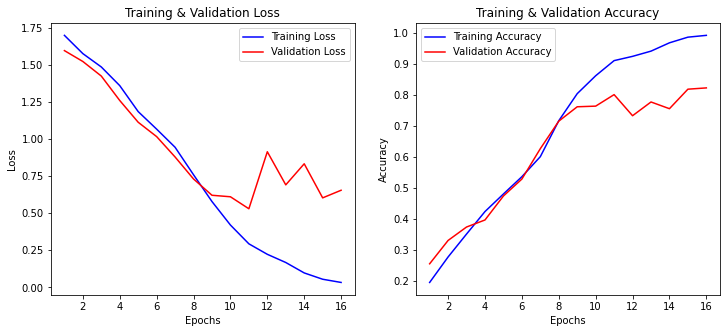

In [34]:
import matplotlib.pyplot as plt

# 모델 학습 실행 (history 저장)
EPOCHS = 100
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=callbacks
)

# 학습 결과(history) 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('accuracy', history.history.get('acc'))  # 'accuracy' 또는 'acc' 키 확인
val_acc = history.history.get('val_accuracy', history.history.get('val_acc'))  # 'val_accuracy' 또는 'val_acc' 키 확인

# 에포크 값 생성
epochs = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [35]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_train = []
y_train = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in train_dataset:
    X_train.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_train.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

pd.value_counts(y_train)


3    606
4    600
1    584
2    582
0    535
dtype: int64

In [36]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_val = []
y_val = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in val_dataset:
    X_val.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_val.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_val = np.array(X_val)
y_val = np.array(y_val)

pd.value_counts(y_val)


3    202
4    200
1    194
2    194
0    179
dtype: int64

In [37]:
temp = np.concatenate([X_train, X_val], axis=0)
temp.shape

(3876, 100)

In [38]:
np.unique(temp, axis=0).shape

(3875, 100)

# Test dataset으로 확인하기

In [39]:
# 모델 평가 (train_dataset을 사용)
model.evaluate(train_dataset)

46/46 [==============================] - 1s 15ms/step - loss: 0.1268 - accuracy: 0.9725


[0.12682723999023438, 0.9724802374839783]

In [40]:
# 모델 평가 (validation_dataset을 사용)
model.evaluate(val_dataset)

16/16 [==============================] - 0s 17ms/step - loss: 0.5296 - accuracy: 0.8008


[0.5296437740325928, 0.8008255958557129]

In [41]:
# 모델 평가 (train_dataset을 사용)
model.evaluate(test_dataset)

16/16 [==============================] - 0s 13ms/step - loss: 0.5356 - accuracy: 0.7959


[0.5356477499008179, 0.7958762645721436]

In [42]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_test = []
y_test = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in test_dataset:
    X_test.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_test.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (970, 100)
y_test shape: (970,)


In [43]:
def get_pred(X_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)
    
    return y_pred

y_pred = get_pred(X_test)
y_pred[:5]

array([4, 3, 0, 3, 3])

In [44]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7365    0.6124    0.6687       178
           1     0.6979    0.8410    0.7628       195
           2     0.9128    0.8093    0.8579       194
           3     0.6726    0.7389    0.7042       203
           4     1.0000    0.9600    0.9796       200

    accuracy                         0.7959       970
   macro avg     0.8040    0.7923    0.7946       970
weighted avg     0.8050    0.7959    0.7970       970



# 추론 및 Submission 저장

In [32]:
def make_submission_df(model, test_df):
    test_conversation = test_df['text'].apply(preprocess_sentence)
    test_conversation = tokenize_and_filter(test_conversation)
    
    y_pred = get_pred(test_conversation)
    
    test_df['target'] = y_pred
    test_df.drop(['text'], axis=1, inplace=True)
    
    return test_df

test_df = make_submission_df(model, test_df)
test_df.to_csv('my_submission.csv', index=False)
test_df.head()

,idx,target
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,2
4,t_004,3
